### Using RGDR
This notebook outlines the current status of the RGDR implementation.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import s2spy.time
import s2spy.rgdr
from s2spy import RGDR

First we will load in some example data, and resample them using the `AdventCalendar`.

In [2]:
file_path = '../tests/test_rgdr/test_data'
field = xr.open_dataset(f'{file_path}/sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc')
target = xr.open_dataset(f'{file_path}/tf5_nc5_dendo_80d77.nc')

Create calendar, map it to dataset and visualize it.

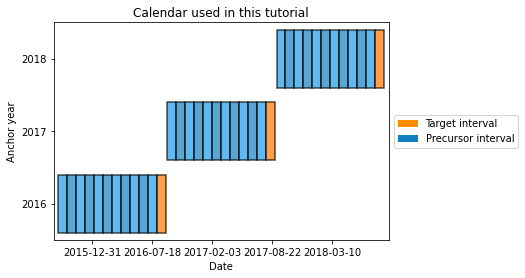

In [3]:
cal = s2spy.time.AdventCalendar("8-2", freq = "30d")
cal = cal.map_to_data(field)
cal.visualize(n_years = 3, relative_dates=False, add_length=False)
_ = plt.title("Calendar used in this tutorial")

Resample data with calendar.

In [4]:
field_resampled = s2spy.time.resample(cal, field)
target_resampled = s2spy.time.resample(cal, target)

### The target timeseries comes from already pre-clustered land surface temperature data.

In [5]:
target_timeseries = target_resampled.sel(cluster=3).ts.sel(i_interval=1)
precursor_field = field_resampled.sst.sel(i_interval=slice(-4,-1)) # Multiple lags: -1 through -4

rgdr = RGDR(eps_km=600, alpha=0.05, min_area_km2=3000**2)

Using `.preview_correlation` we can visualize the correlation and p-value map of the target timeseries and precursor field, for a single lag.

In this case we use lag `-1`.

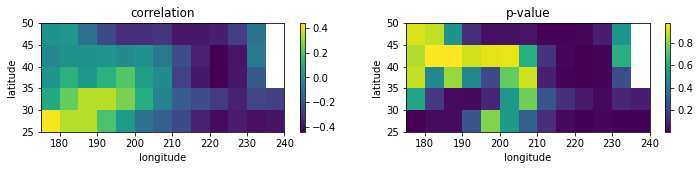

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 2))
rgdr.preview_correlation(precursor_field, target_timeseries, i_interval=-1, ax1=ax1, ax2=ax2)

Using the preview utilities we can compare two RGDR setups, and see what the effect on the generated clusters will be.

Note that the second figure has an extra cluster, due to the minimum area argument having a smaller value.

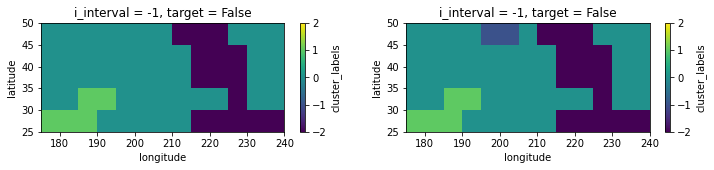

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 2))

RGDR(eps_km=600, min_area_km2=3000**2).preview_clusters(precursor_field,
                                                        target_timeseries,
                                                        i_interval=-1, ax=ax1)

RGDR(eps_km=600, min_area_km2=None).preview_clusters(precursor_field,
                                                     target_timeseries,
                                                     i_interval=-1, ax=ax2)

Once you are satisfied with the selected paramters, the `.fit` method can be used to fit the RGDR clustering to a precursor field.

`.transform` can then be used to return the data reduced to clusters:

In [8]:
rgdr.fit(precursor_field, target_timeseries)
clustered_data = rgdr.transform(precursor_field)
xr.set_options(display_expand_data=False) # Hide the full data repr
clustered_data

<xarray.DataArray 'sst' (anchor_year: 39, cluster_labels: 6)>
291.4 298.2 288.4 296.6 286.9 285.1 ... 290.8 298.9 287.8 296.6 286.0 284.9
Coordinates:
  * anchor_year     (anchor_year) int64 2018 2017 2016 2015 ... 1982 1981 1980
  * cluster_labels  (cluster_labels) <U32 'i_interval:-1_cluster:-2' ... 'i_i...
    latitude        (cluster_labels) float64 36.05 29.44 37.33 29.58 38.14 39.78
    longitude       (cluster_labels) float64 223.9 185.4 221.8 190.2 217.8 219.3
Attributes:
    data:         Clustered data with Response Guided Dimensionality Reduction.
    coordinates:  Latitudes and longitudes are geographical centers associate...

Now we can plot the data for each cluster:

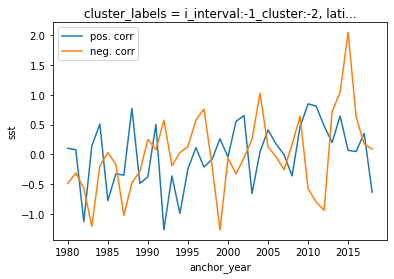

In [9]:
import matplotlib.pyplot as plt

clustered_data -= clustered_data.mean(dim='anchor_year')
clustered_data.sel(cluster_labels="i_interval:-1_cluster:1").plot.line(x='anchor_year', label='pos. corr')
clustered_data.sel(cluster_labels="i_interval:-1_cluster:-2").plot.line(x='anchor_year', label='neg. corr')
plt.legend()

The `RGDR` object will also contain the correlation maps, p-values, and cluster maps.

These are all `xr.DataArray` objects, and can easily be plot using the builtin methods:

In [10]:
# View the contents of the corr_map DataArray:
rgdr.corr_map

<xarray.DataArray (latitude: 5, longitude: 13, i_interval: 4)>
-0.2663 -0.2194 -0.2187 0.01618 -0.1819 ... -0.1126 -0.3063 -0.38 -0.3984
Coordinates:
  * latitude    (latitude) float64 47.5 42.5 37.5 32.5 27.5
  * longitude   (longitude) float64 177.5 182.5 187.5 ... 227.5 232.5 237.5
  * i_interval  (i_interval) int64 -4 -3 -2 -1
    area        (latitude) float64 3.34e+06 3.645e+06 ... 4.169e+06 4.385e+06
    tfreq       int64 5
    n_clusters  int64 6
    cluster     int64 3

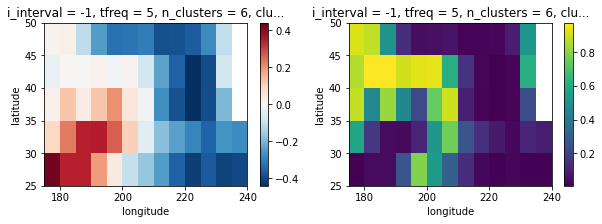

In [11]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 3), ncols=2)

# Visualize correlation map after RGDR().fit(precursor_field, target_timeseries)
rgdr.corr_map.sel(i_interval=-1).plot(ax=ax1)

# Visualize p-values map
rgdr.pval_map.sel(i_interval=-1).plot(ax=ax2)

The cluster maps can also be visualized. Note that clusters can differ between lags.

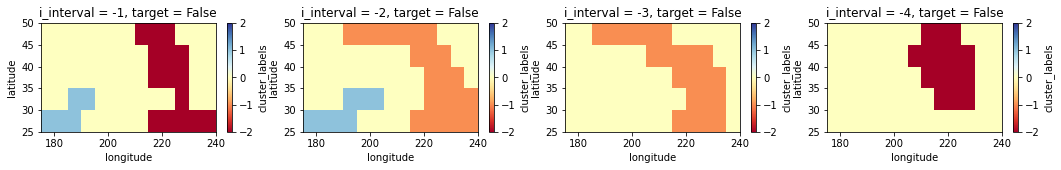

In [12]:
from s2spy.rgdr.utils import cluster_labels_to_ints
cluster_map = cluster_labels_to_ints(rgdr.cluster_map.copy())

fig, axes = plt.subplots(figsize=(18, 2), ncols=4)

# Loop through lag -1 -> -4
for i, ax in zip((-1, -2, -3, -4), axes):
    cluster_map.cluster_labels.sel(i_interval=i).plot(ax=ax, cmap='RdYlBu', vmin=-2, vmax=2)